# Exploratory Notebook

## Ideas

**How can we optimise the image encoding method for a stable renderer such that human participants can best infer the original *information*?** (not necessarily the original image, just what it represents).

Moreso, how can we do this ***without* knowing what the renderer looks like**?

### "Half"-Autoencoder

Auto-encoders typically train an encoding and decoding network to match an input to the output. 

Can restrictions be placed on the decoding network such that a "half"-autoencoder could be trained? (i.e. training the network to match input to the output, but making most of the training occur in the encoder?)




# Flow

## Digit to Image

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [3]:
def digit_to_image(digit : int, xloc : float, yloc : float):
    fig = plt.figure(figsize=(1,1))
    canvas = FigureCanvas(fig)
    ax = plt.gca()
    fig.patch.set_facecolor('black')
    plt.axis('off')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.text(xloc, yloc, str(digit),
             size=48,
             color='white',
             clip_box=ax.clipbox,
             clip_on=True,
             horizontalalignment = 'center',
             verticalalignment = 'center',
             linespacing = 0,
             #bbox=dict(facecolor='red', alpha=0.5),
             transform=ax.transAxes)
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    plt.close(fig)
    return image

In [4]:
%time test = digit_to_image(9,0.5, 0.5)

Wall time: 30 ms


In [5]:
np.shape(test)

(72, 72, 3)

## Image to Digit

In [7]:
import tensorflow as tf
tf.executing_eagerly()
import keras

Using TensorFlow backend.


In [11]:
import skimage.color as color

In [12]:
# %%time

digit_train_n = 1200
digit_train_truth = np.random.randint(0, 10, digit_train_n)
digit_train_data =  np.array([color.rgb2gray(digit_to_image(digit, random.random()/2, random.random()/2)) for digit in digit_train_truth])

digit_test_n = 600
digit_test_truth = np.random.randint(0, 10, digit_test_n)
digit_test_data =  np.array([color.rgb2gray(digit_to_image(digit, random.random()/2, random.random()/2)) for digit in digit_test_truth])

In [13]:
input_shape = (72, 72)

In [14]:
digit_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(144, activation=tf.nn.relu),  
    tf.keras.layers.Dense(64, activation=tf.nn.relu), 
    #tf.keras.layers.Dense(16, activation=tf.nn.relu), 
    #tf.keras.layers.Dense(64, activation=tf.nn.relu),  
    #tf.keras.layers.Dense(32, activation=tf.nn.relu),  
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [15]:
digit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
digit_model.fit(digit_train_data, digit_train_truth, epochs=10)

Epoch 1/10
1200/1200 [==============================] - 0s 307us/sample - loss: 2.2889 - accuracy: 0.1617
Epoch 2/10
1200/1200 [==============================] - 0s 187us/sample - loss: 1.9307 - accuracy: 0.3475
Epoch 3/10
1200/1200 [==============================] - 0s 187us/sample - loss: 1.5478 - accuracy: 0.5175
Epoch 4/10
1200/1200 [==============================] - 0s 184us/sample - loss: 1.1473 - accuracy: 0.6642
Epoch 5/10
1200/1200 [==============================] - 0s 184us/sample - loss: 0.8317 - accuracy: 0.7733
Epoch 6/10
1200/1200 [==============================] - 0s 185us/sample - loss: 0.5667 - accuracy: 0.8417
Epoch 7/10
1200/1200 [==============================] - 0s 192us/sample - loss: 0.4040 - accuracy: 0.9050
Epoch 8/10
1200/1200 [==============================] - 0s 186us/sample - loss: 0.2958 - accuracy: 0.9342
Epoch 9/10
1200/1200 [==============================] - 0s 185us/sample - loss: 0.2345 - accuracy: 0.9467
Epoch 10/10
1200/1200 [=======================

In [17]:
digit_model.evaluate(digit_test_data, digit_test_truth)

600/600 [==============================] - 0s 172us/sample - loss: 0.8150 - accuracy: 0.7517


[0.8149743906656901, 0.75166667]

In [18]:
predictions = digit_model.predict_on_batch(digit_test_data)

In [19]:
classes = [np.argmax(prediction) for prediction in predictions]

In [20]:
correct = [x[0] == x[1] for x in zip(classes, digit_test_truth)]

## Image to Phosphenes

In [21]:
import os
import sys
sys.path.append(os.path.split(os.getcwd())[0])

In [22]:
from phosphenes import *

In [23]:
%time grid = PolarRegularGrid(12, 12, 64, 64)

Wall time: 38 ms


In [24]:
%time stimulus = Stimulus(color.rgb2gray(test), grid)

Wall time: 982 µs


In [25]:
%time render = grid.render(stimulus.vector)

Wall time: 3.98 ms


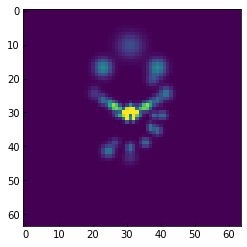

In [26]:
plt.imshow(render)

In [27]:
def image_to_phosphenes(image : np.ndarray):
    global grid
    stimulus = Stimulus(color.rgb2gray(image), grid)
    render = grid.render(stimulus.vector)
    #plt.imshow(render, cmap='gray')
    return (render + 1) / 2

In [28]:
%time render = image_to_phosphenes(digit_to_image(6, 0.5, 0.45))

Wall time: 16 ms


## Phosphenes to Digit

In [29]:
import tensorflow as tf
import keras
import numpy as np

In [30]:
train_n = 1200
train_truth = np.random.randint(0, 10, train_n)

In [31]:
%time train_data = np.array([image_to_phosphenes(digit_to_image(digit, 0.5, 0.5)) for digit in train_truth])

Wall time: 18.7 s


In [32]:
test_n = 600
test_truth = np.random.randint(0, 10, test_n)

In [33]:
%time test_data = np.array([image_to_phosphenes(digit_to_image(digit, 0.5, 0.5)) for digit in test_truth ])

Wall time: 8.97 s


In [34]:
input_shape = (64, 64)

In [35]:
decode_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),  
    tf.keras.layers.Dense(64, activation=tf.nn.relu),  
    tf.keras.layers.Dense(32, activation=tf.nn.relu),  
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [36]:
decode_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
decode_model.fit(train_data, train_truth, epochs=10)

Epoch 1/10
1200/1200 [==============================] - 0s 217us/sample - loss: 1.0210 - accuracy: 0.9025
Epoch 2/10
1200/1200 [==============================] - 0s 136us/sample - loss: 0.0163 - accuracy: 1.0000
Epoch 3/10
1200/1200 [==============================] - 0s 127us/sample - loss: 0.0031 - accuracy: 1.0000
Epoch 4/10
1200/1200 [==============================] - 0s 131us/sample - loss: 0.0019 - accuracy: 1.0000
Epoch 5/10
1200/1200 [==============================] - 0s 127us/sample - loss: 0.0013 - accuracy: 1.0000
Epoch 6/10
1200/1200 [==============================] - 0s 128us/sample - loss: 9.7732e-04 - accuracy: 1.0000
Epoch 7/10
1200/1200 [==============================] - 0s 135us/sample - loss: 7.3922e-04 - accuracy: 1.0000
Epoch 8/10
1200/1200 [==============================] - 0s 128us/sample - loss: 5.7016e-04 - accuracy: 1.0000
Epoch 9/10
1200/1200 [==============================] - 0s 132us/sample - loss: 4.5251e-04 - accuracy: 1.0000
Epoch 10/10
1200/1200 [=======

In [38]:
decode_model.evaluate(test_data, test_truth)

600/600 [==============================] - 0s 136us/sample - loss: 3.2577e-04 - accuracy: 1.0000


[0.0003257651145880421, 1.0]

# Encoding Network

In [39]:
test = color.rgb2gray(digit_to_image(9, 0.5, 0.5))

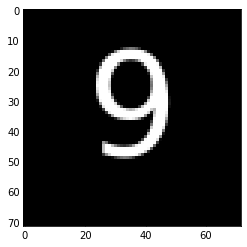

In [40]:
plt.imshow(test, cmap='gray')

In [41]:
input_shape = (72, 72)

In [42]:
output_shape = (12, 12)

In [43]:
def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    model.add(tf.keras.layers.Dense(12*12*6))
    model.add(tf.keras.layers.Dense(12*12))
    print(model.output_shape)
    return model

In [44]:
test_batch = np.array([test])

In [45]:
test_tensor = tf.convert_to_tensor(test_batch, dtype=tf.float32)

(None, 144)


In [47]:
test_encode = encoder(test_tensor)

In [48]:
test_render = grid.render(test_encode.numpy()[0])

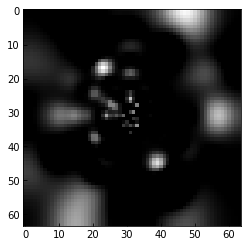

In [49]:
plt.imshow(test_render, cmap='gray')

In [50]:
def decision(encoded):
    encoded_np = encoded.numpy()
    rendered = grid.render(encoded_np[0])
    result = decode_model.predict(np.array([rendered]))
    return result

In [51]:
decision(test_encode)

array([[1.9307850e-03, 1.5232280e-03, 4.6957202e-02, 1.4840397e-03,
        1.0372738e-02, 5.3544316e-02, 8.4520668e-01, 1.7476090e-05,
        8.9755590e-04, 3.8066015e-02]], dtype=float32)

In [52]:
cce = tf.keras.losses.CategoricalCrossentropy()

In [53]:
encoder_optimiser = tf.keras.optimizers.Adam(1e-4)

In [54]:
EPOCHS = 10

In [100]:
#@tf.function
def train_step(digit):
    
    image = color.rgb2gray(digit_to_image(digit, 0.5, 0.5))
    image_tensor = tf.convert_to_tensor(np.array([image]), dtype=tf.float32)
    
    with tf.GradientTape() as encoder_tape:
        
        encoder = make_encoder_model()
        encoded = encoder(image_tensor, training=True)
        encoded_np = encoded.numpy()
        rendered = grid.render(encoded_np[0])
        image_decision = decode_model.predict(np.array([rendered]))
        base = np.zeros(10)
        base[digit] = 1
        result = (base, image_decision)
        
        loss = cce(*result)
        
    gradient = encoder_tape.gradient(loss, encoder.trainable_variables)
    encoder_optimiser.apply_gradients(zip(gradient, encoder.trainable_variables))

In [101]:
def train(epochs):
    for digit in np.random.randint(0, 10, 1000):
        train_step(digit)

In [102]:
train(EPOCHS)

(None, 144)


ValueError: No gradients provided for any variable: ['dense_21/kernel:0', 'dense_21/bias:0', 'dense_22/kernel:0', 'dense_22/bias:0'].